## Import necesary libraries

In [1]:
import os
import pandas as pd
import numpy as np
from PIL import Image
from sklearn import preprocessing
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix

import seaborn as sns
import matplotlib.pyplot as plt

## Load Dataset

In [2]:
def load_images_from_folder(root_folder):
    """
    Load images and corresponding labels from a folder structure.

    Parameters:
    - root_folder (str): The path to the root folder containing subdirectories with images.

    Returns:
    - image_paths (list): List of paths to the loaded images.
    - images (list): List of numpy arrays representing the loaded images.
    - labels (list): List of corresponding labels for each image.
    """
    
    # Lists to store image paths, images, and corresponding labels
    image_paths = []
    images = []
    labels = []

    # Iterate over subdirectories (labels) in the root folder
    for label in os.listdir(root_folder):
        label_path = os.path.join(root_folder, label)

        # Check if the path corresponds to a directory
        if os.path.isdir(label_path):
            # Iterate over files in the label directory
            for filename in os.listdir(label_path):
                img_path = os.path.join(label_path, filename)

                # Check if the file is a valid image (jpg or png)
                if os.path.isfile(img_path) and (filename.endswith(".jpg") or filename.endswith(".png")):
                    # Open the image using PIL
                    img = Image.open(img_path)
                    
                    # Resize or preprocess the image if needed
                    img = img.resize((128, 128))
                    
                    # Convert the image to a numpy array
                    img_array = np.array(img)

                    # Store the image path, image array, and label
                    image_paths.append(img_path)
                    images.append(img_array)
                    labels.append(label)

    # Return the lists containing image paths, images, and labels
    return image_paths, images, labels

if __name__ == "__main__":
    # Specify the root folder path containing subdirectories with images
    root_folder_path = "Micro_Organism"

    # Load images and labels from the specified root folder
    image_paths, images, labels = load_images_from_folder(root_folder_path)

In [3]:
# Convert images and labels to DataFrame
data = {"Images": image_paths, "Labels": labels}
df = pd.DataFrame(data)

# Convert DataFrame to CSV
df.to_csv("micro_organism_image_classification_original_data.csv", index=False)

In [4]:
csv_file = "micro_organism_image_classification_original_data.csv"
df = pd.read_csv(csv_file)

In [5]:
df.head()

Images           Labels
0  Micro_Organism/Spiral_bacteria/Image_15.jpg  Spiral_bacteria
1  Micro_Organism/Spiral_bacteria/Image_29.jpg  Spiral_bacteria
2   Micro_Organism/Spiral_bacteria/image77.jpg  Spiral_bacteria
3  Micro_Organism/Spiral_bacteria/Image_28.jpg  Spiral_bacteria
4  Micro_Organism/Spiral_bacteria/Image_14.jpg  Spiral_bacteria

In [6]:
df.shape

(769, 2)

In [7]:
df["Labels"].value_counts()

Euglena               165
Paramecium            149
Spherical_bacteria     86
Rod_bacteria           79
Spiral_bacteria        73
Yeast                  73
Amoeba                 72
Hydra                  72
Name: Labels, dtype: int64

Image Shape: (1280, 720)


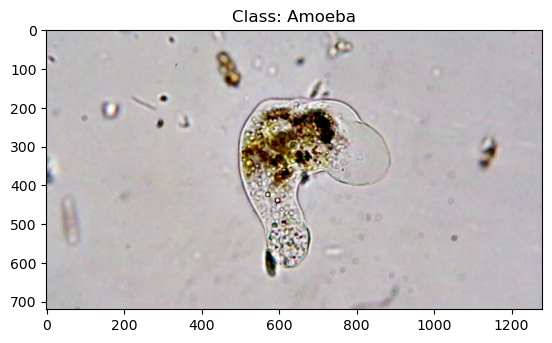

Image Shape: (480, 360)


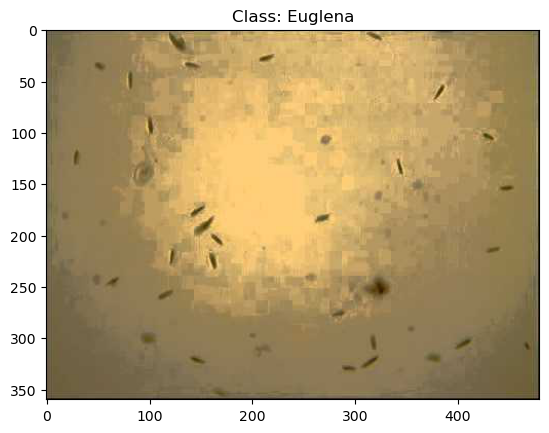

Image Shape: (1600, 900)


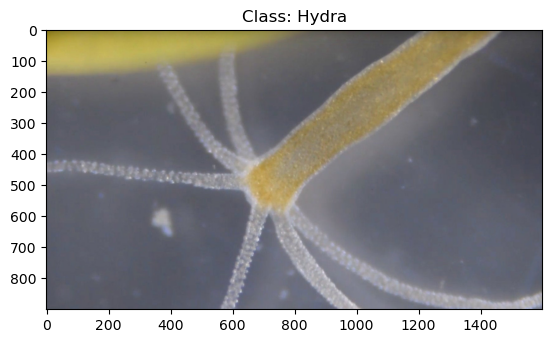

Image Shape: (1280, 720)


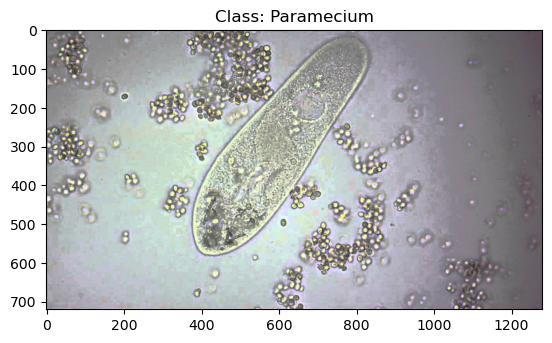

Image Shape: (800, 450)


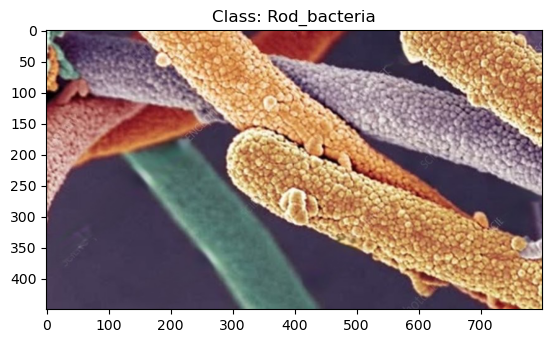

Image Shape: (180, 195)


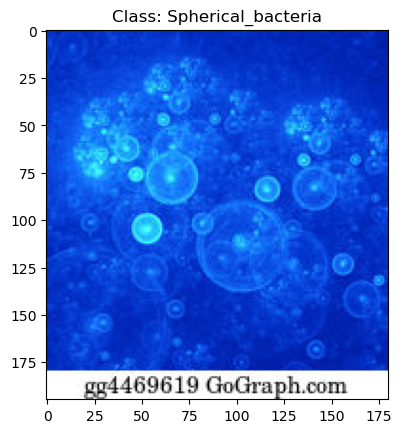

Image Shape: (480, 360)


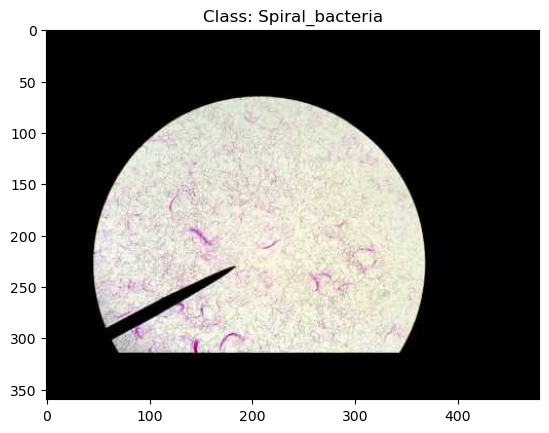

Image Shape: (700, 484)


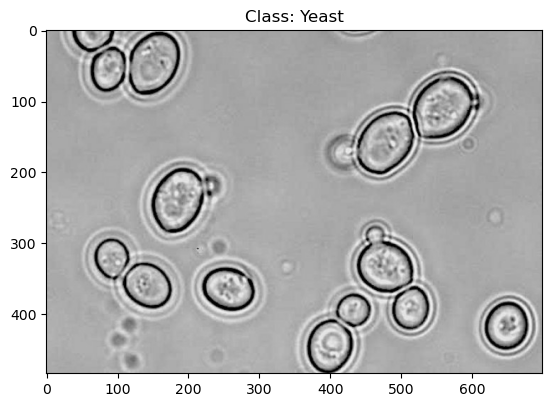

In [8]:
def show_one_image_per_class(csv_file):
    """
    Load the CSV file, extract one image for each class, and display the images.

    Parameters:
    - csv_file (str): Path to the CSV file containing image paths and labels.

    Returns:
    None
    """
    # Load the CSV file into a DataFrame
    df = pd.read_csv(csv_file)

    # Group the DataFrame by the 'Labels' column and sample one image path per group
    sampled_images = df.groupby('Labels').apply(lambda x: x.sample(1))

    # Display one image for each class
    for index, row in sampled_images.iterrows():
        img_path = row['Images']
        label = row['Labels']

        # Open and display the image
        img = Image.open(img_path)
        
        # Print the shape of the image
        print(f"Image Shape: {img.size}")
        
        plt.imshow(img)
        plt.title(f"Class: {label}")
        plt.show()


# Call the function to display one image for each class
show_one_image_per_class(csv_file)

## Data Augmenation

In [ ]:
def augment_data(images, labels, target_num_images, output_folder):
    """
    Augment the given dataset to achieve the target number of images per class.

    Parameters:
    - images: List of input images (numpy arrays).
    - labels: List of corresponding labels for each image.
    - target_num_images: Target number of images per class after augmentation.
    - output_folder: Path to the folder where augmented images will be saved.

    Returns:
    None
    """
    # Create an ImageDataGenerator for data augmentation
    datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    # Iterate over unique labels in the dataset
    for label in set(labels):
        # Get images corresponding to the current label
        label_images = [img for img, lbl in zip(images, labels) if lbl == label]
        num_images = len(label_images)
        num_augmentations = target_num_images - num_images

        # Print information about the label and augmentation process
        print(f"Label: {label}, Original Images: {num_images}, Augmentations: {num_augmentations}")

        # If additional augmentations are needed for the current label
        if num_augmentations > 0:
            # Create a subfolder for the current label within the output folder
            output_folder_label = os.path.join(output_folder, label)
            os.makedirs(output_folder_label, exist_ok=True)

            # Augment each original image and save the augmented images
            for img_array in label_images:
                img = Image.fromarray(img_array)
                img = img.convert('RGB')
                img_array = np.array(img)
                img_array = img_array.reshape((1,) + img_array.shape)

                # Apply data augmentation and save the augmented images
                i = 0
                for batch in datagen.flow(img_array, batch_size=1, save_to_dir=output_folder_label, save_prefix=label, save_format='jpg'):
                    i += 1
                    if i >= num_augmentations:
                        break

# example
output_folder_path = "Augmented_Data"
target_num_images_per_class = 200  

# Augment data
augment_data(images, labels, target_num_images_per_class, output_folder_path)

In [ ]:
# Load images and labels
output_folder_path = "Augmented_Data"
augmented_image_paths, augment_images, augment_labels = load_images_from_folder(output_folder_path)

In [ ]:
# Convert images and labels to DataFrame
data = {"Images": augmented_image_paths, "Labels": augment_labels}
df = pd.DataFrame(data)

In [ ]:
# Define a function to encode labels using LabelEncoder
def encode_labels(labels):
    # Create a LabelEncoder object
    le = preprocessing.LabelEncoder()
    
    # Fit and transform the input labels to encoded labels
    encoded_labels = le.fit_transform(labels)
    
    # Return the encoded labels and the unique classes in the original labels
    return encoded_labels, le.classes_

# Call the encode_labels function with the labels we want to encode
# augment_labels is assumed to be a list or array containing the labels 
encoded_labels, classes = encode_labels(augment_labels)

# Add a new column 'Encoded_Labels' to the DataFrame with the encoded labels
df['Encoded_Labels'] = encoded_labels

In [ ]:
# Convert DataFrame to CSV
df.to_csv("micro_organism_image_classification_augmented_data.csv", index=False)

In [9]:
augmented_csvFile = "micro_organism_image_classification_augmented_data.csv"
df = pd.read_csv(augmented_csvFile)

In [10]:
df.head()

Images           Labels  \
0  Augmented_Data/Spiral_bacteria/Spiral_bacteria...  Spiral_bacteria   
1  Augmented_Data/Spiral_bacteria/Spiral_bacteria...  Spiral_bacteria   
2  Augmented_Data/Spiral_bacteria/Spiral_bacteria...  Spiral_bacteria   
3  Augmented_Data/Spiral_bacteria/Spiral_bacteria...  Spiral_bacteria   
4  Augmented_Data/Spiral_bacteria/Spiral_bacteria...  Spiral_bacteria   

   Encoded_Labels  
0               6  
1               6  
2               6  
3               6  
4               6

In [12]:
df.shape

(46313, 3)

In [13]:
df["Labels"].value_counts()

Spherical_bacteria    6244
Rod_bacteria          6217
Spiral_bacteria       6064
Hydra                 6058
Yeast                 6052
Amoeba                6035
Paramecium            5291
Euglena               4352
Name: Labels, dtype: int64

Image Shape: (128, 128)


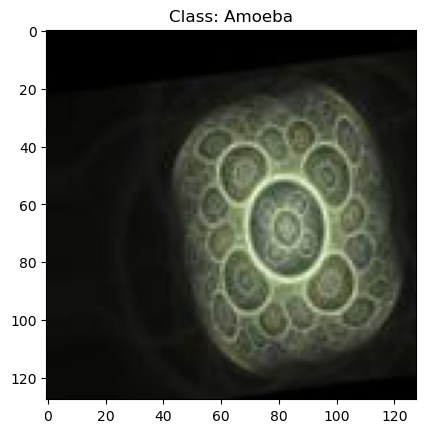

Image Shape: (128, 128)


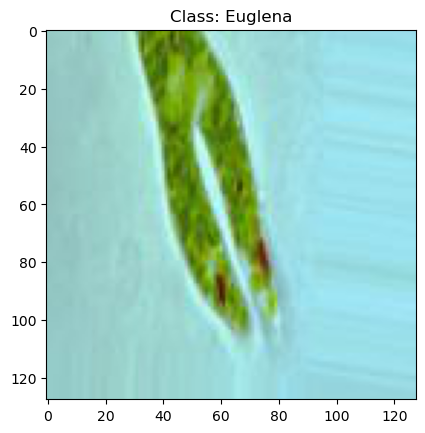

Image Shape: (128, 128)


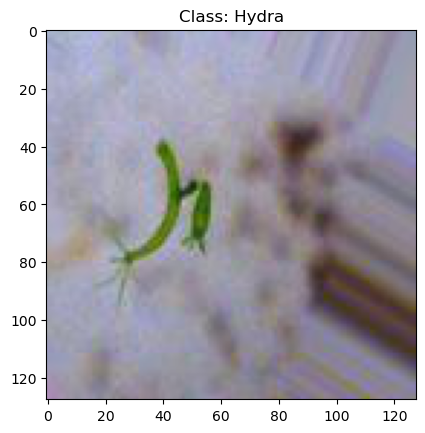

Image Shape: (128, 128)


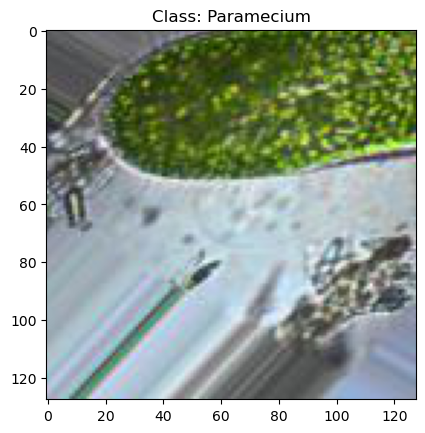

Image Shape: (128, 128)


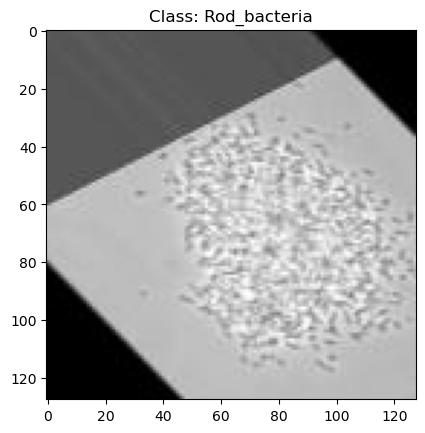

Image Shape: (128, 128)


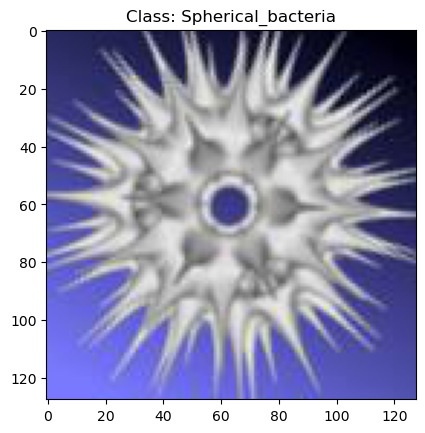

Image Shape: (128, 128)


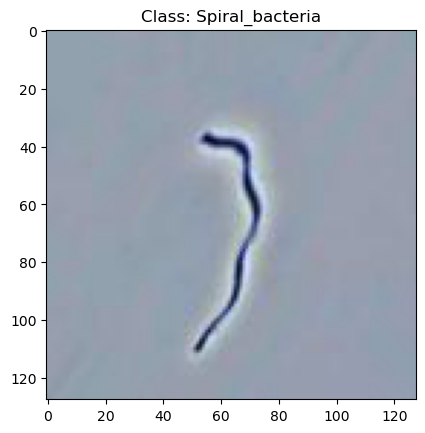

Image Shape: (128, 128)


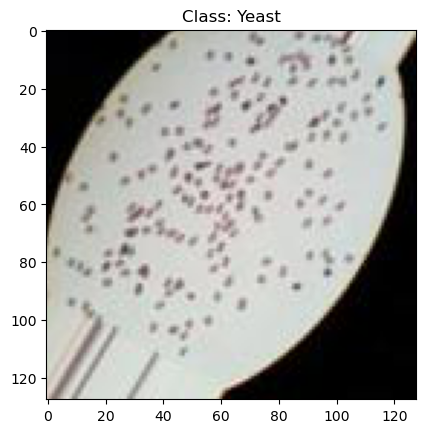

In [11]:
# Call the function to display one image for each class
show_one_image_per_class(augmented_csvFile)

## Model Training

In [8]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

# Convert 'Encoded_Labels' column to integers
df['Encoded_Labels'] = df['Encoded_Labels'].astype(int)

# Split the dataset into training and testing sets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Load and preprocess images for training
def load_and_preprocess_images(file_paths, target_size=(128, 128)):
    images = []
    for file_path in file_paths:
        img = Image.open(file_path)
        img = img.resize(target_size)
        img_array = np.array(img) / 255.0  # Normalize pixel values
        images.append(img_array)
    return np.array(images)

# Load and preprocess training images
X_train = load_and_preprocess_images(train_df['Images'].values)
y_train = train_df['Encoded_Labels'].values

# Create a simple CNN model with regularization
model = keras.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(256, activation='relu', kernel_regularizer=l2(0.05)),
    layers.Dropout(0.5),
    layers.Dense(len(df['Encoded_Labels'].unique()), activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Add EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with the EarlyStopping callback
model.fit(X_train, y_train, epochs=100, batch_size=64, validation_split=0.20, callbacks=[early_stopping])

Epoch 1/100
160/160 [==============================] - 46s 285ms/step - loss: 2.9961 - accuracy: 0.2211 - val_loss: 2.0671 - val_accuracy: 0.3000
Epoch 2/100
160/160 [==============================] - 47s 293ms/step - loss: 2.0676 - accuracy: 0.2896 - val_loss: 2.1495 - val_accuracy: 0.2801
Epoch 3/100
160/160 [==============================] - 48s 300ms/step - loss: 2.0098 - accuracy: 0.3196 - val_loss: 1.9653 - val_accuracy: 0.3223
Epoch 4/100
160/160 [==============================] - 48s 302ms/step - loss: 1.9695 - accuracy: 0.3505 - val_loss: 1.9416 - val_accuracy: 0.3484
Epoch 5/100
160/160 [==============================] - 49s 304ms/step - loss: 1.9395 - accuracy: 0.3636 - val_loss: 1.8504 - val_accuracy: 0.3758
Epoch 6/100
160/160 [==============================] - 85s 535ms/step - loss: 1.8884 - accuracy: 0.3871 - val_loss: 1.9052 - val_accuracy: 0.3598
Epoch 7/100
160/160 [==============================] - 48s 301ms/step - loss: 1.8681 - accuracy: 0.3991 - val_loss: 1.8644 -

Epoch 57/100
160/160 [==============================] - 8231s 52s/step - loss: 1.2132 - accuracy: 0.7539 - val_loss: 1.2214 - val_accuracy: 0.7520
Epoch 58/100
160/160 [==============================] - 7736s 49s/step - loss: 1.2130 - accuracy: 0.7556 - val_loss: 1.2974 - val_accuracy: 0.7258
Epoch 59/100
160/160 [==============================] - 1740s 11s/step - loss: 1.2196 - accuracy: 0.7433 - val_loss: 1.2941 - val_accuracy: 0.7152
Epoch 60/100
160/160 [==============================] - 55s 346ms/step - loss: 1.2164 - accuracy: 0.7514 - val_loss: 1.2828 - val_accuracy: 0.7367
Epoch 61/100
160/160 [==============================] - 57s 355ms/step - loss: 1.1862 - accuracy: 0.7654 - val_loss: 1.2163 - val_accuracy: 0.7535
Epoch 62/100
160/160 [==============================] - 641s 4s/step - loss: 1.1553 - accuracy: 0.7796 - val_loss: 1.2245 - val_accuracy: 0.7504
Epoch 63/100
160/160 [==============================] - 47s 292ms/step - loss: 1.2289 - accuracy: 0.7582 - val_loss: 1.2

In [13]:
# Save the model
model.save('trained_model.h5')

In [14]:
import pickle
# Save the model to a file using pickle
model_filename = 'trained_model.pkl'
with open(model_filename, 'wb') as file:
    pickle.dump(model, file)

print(f'Model saved to {model_filename}')

Model saved to trained_model.pkl


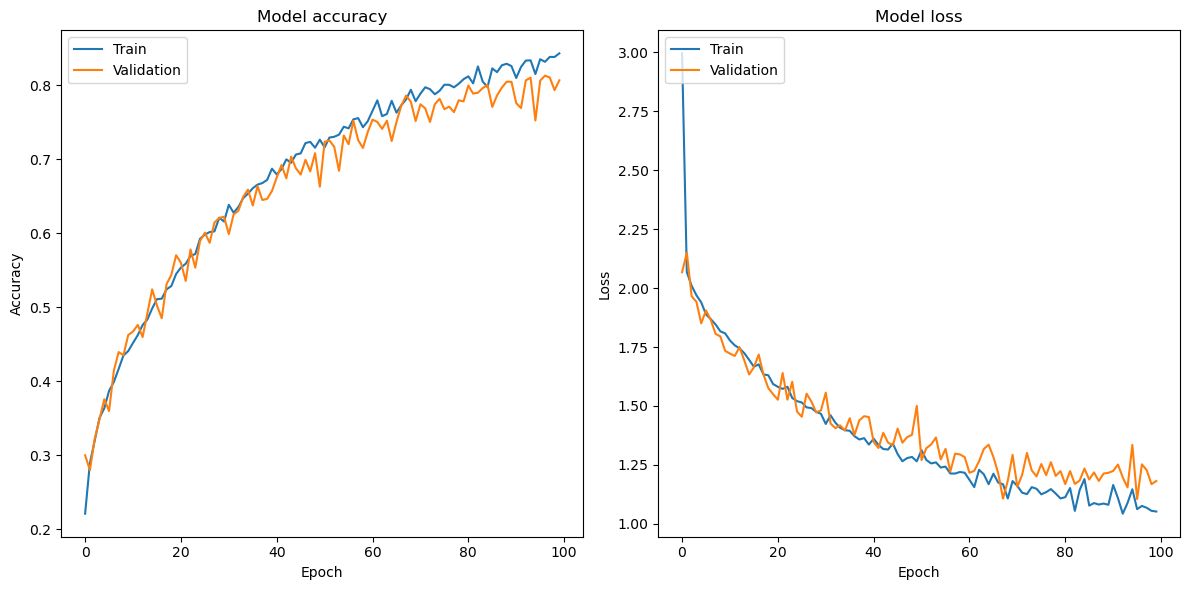

In [15]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

## Model Evaluation

In [20]:
import pickle

# path to the trained model pickle file
model_file_path = 'trained_model.pkl'

# Load the model from the pickle file
with open(model_file_path, 'rb') as file:
    loaded_model = pickle.load(file)

In [36]:
# Encode labels
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(df['Labels'])
classes = label_encoder.classes_

print(classes)

['Amoeba' 'Euglena' 'Hydra' 'Paramecium' 'Rod_bacteria'
 'Spherical_bacteria' 'Spiral_bacteria' 'Yeast']


In [37]:
# Save the label encoder to a file
label_encoder_file_path = 'label_encoder.pkl'
with open(label_encoder_file_path, 'wb') as label_encoder_file:
    pickle.dump(label_encoder, label_encoder_file)

print(f"Label encoder saved to {label_encoder_file_path}")


Label encoder saved to label_encoder.pkl


In [25]:
# Load and preprocess images for testing
X_test = load_and_preprocess_images(test_df['Images'].values)
y_test = test_df['Encoded_Labels'].values

# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test accuracy: {accuracy * 100:.2f}%')

# Get predictions for the test set
y_prob = model.predict(X_test)
y_pred = np.argmax(y_prob, axis=1)

# Generate the classification report
class_report = classification_report(y_test, y_pred, target_names=classes)
print("Classification Report:\n", class_report)

100/100 [==============================] - 4s 38ms/step - loss: 1.1295 - accuracy: 0.8075
Test accuracy: 80.75%
100/100 [==============================] - 4s 38ms/step
Classification Report:
                     precision    recall  f1-score   support

            Amoeba       0.79      0.77      0.78       421
           Euglena       0.83      0.82      0.82       395
             Hydra       0.83      0.98      0.90       368
        Paramecium       0.78      0.68      0.73       400
      Rod_bacteria       0.75      0.81      0.78       459
Spherical_bacteria       0.80      0.74      0.77       416
   Spiral_bacteria       0.78      0.81      0.79       372
             Yeast       0.91      0.88      0.90       369

          accuracy                           0.81      3200
         macro avg       0.81      0.81      0.81      3200
      weighted avg       0.81      0.81      0.81      3200



## Evaluating Model Predictions on Test Data

1/1 [==============================] - 0s 16ms/step


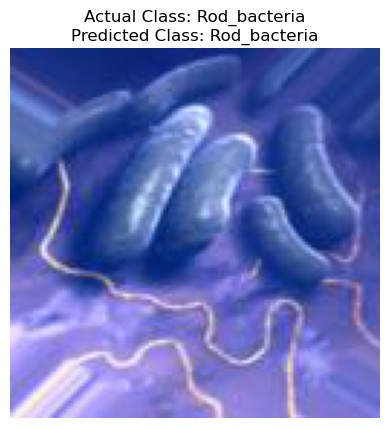

In [27]:
def showcase_test_image(model, test_df, classes, index=0):
    """
    Showcase one test image along with its predicted class and actual class.

    Parameters:
    - model: Trained Keras model
    - test_df: DataFrame containing test data
    - classes: List of class labels
    - index: Index of the test image to showcase (default is 0)

    Returns:
    None
    """
    # Load and preprocess the chosen test image
    test_image = load_and_preprocess_images([test_df['Images'].values[index]])
    actual_label = classes[test_df['Encoded_Labels'].values[index]]

    # Get the model's prediction for the test image
    predicted_prob = model.predict(test_image)
    predicted_label = classes[np.argmax(predicted_prob)]

    # Display the test image along with its predicted and actual classes
    plt.imshow(test_image[0])
    plt.title(f"Actual Class: {actual_label}\nPredicted Class: {predicted_label}")
    plt.axis('off')
    plt.show()

# Example:
showcase_test_image(model, test_df, classes, index=0)


1/1 [==============================] - 0s 18ms/step


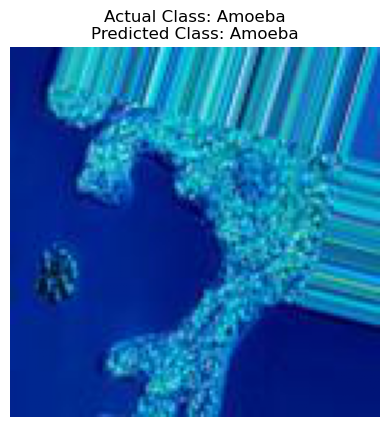

In [29]:
showcase_test_image(model, test_df, classes, index=20)

1/1 [==============================] - 0s 16ms/step


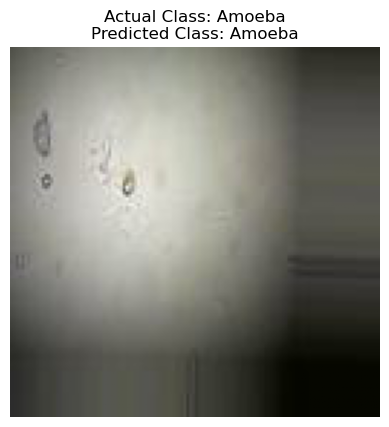

In [30]:
showcase_test_image(model, test_df, classes, index=36)

1/1 [==============================] - 0s 15ms/step


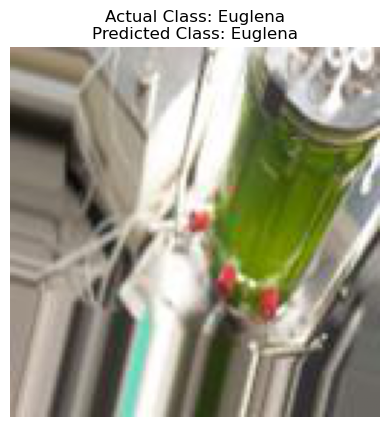

In [32]:
showcase_test_image(model, test_df, classes, index=237)